# Recurrent Neural Networks: Stability Analysis and LSTMs

---

## Table of Contents
1. [Linear RNN Stability Analysis](#1-linear-rnn-stability-analysis)
2. [Effect of Nonlinear Activations on Memory](#2-effect-of-nonlinear-activations-on-memory)
3. [Vanishing / Exploding Gradients (Chain Rule View)](#3-vanishing--exploding-gradients-chain-rule-view)
4. [Long Short-Term Memory (LSTM)](#4-long-short-term-memory-lstm)

---

# 1. Linear RNN Stability Analysis

## 1.1 Problem Setup

**Why study linear RNNs first?**

Before tackling nonlinear networks, we must understand the fundamental dynamics of recurrent systems. A linear RNN provides analytical tractability while revealing the core stability issues that plague all RNNs.

---

**Standard RNN Hidden State Update:**

A vanilla (linear) RNN hidden state evolves according to:

$$
\mathbf{h}_t = W \, \mathbf{h}_{t-1} + C \, \mathbf{x}_t
$$

where:
- $\mathbf{h}_t \in \mathbb{R}^n$ is the hidden state at time $t$
- $W \in \mathbb{R}^{n \times n}$ is the recurrent weight matrix
- $C \in \mathbb{R}^{n \times m}$ is the input weight matrix
- $\mathbf{x}_t \in \mathbb{R}^m$ is the input at time $t$

---

**Homogeneous System for Stability Analysis:**

To understand long-term behavior, it is sufficient to analyze the **homogeneous system** (setting inputs to zero):

$$
\mathbf{h}_t = W \, \mathbf{h}_{t-1}
$$

> **Justification:** Input effects are additive and do not change the asymptotic stability properties. The system's intrinsic dynamics are determined solely by $W$.

---

## 1.2 Closed-Form Solution

By repeated substitution:

$$
\begin{aligned}
\mathbf{h}_1 &= W \, \mathbf{h}_0 \\
\mathbf{h}_2 &= W \, \mathbf{h}_1 = W^2 \, \mathbf{h}_0 \\
&\;\;\vdots \\
\mathbf{h}_t &= W^t \, \mathbf{h}_0
\end{aligned}
$$

> **Key Observation:** The stability of the hidden state depends **entirely** on the behavior of matrix powers $W^t$ as $t \to \infty$.

---

## 1.3 Eigenvalue Decomposition

**Assumption:** $W$ is diagonalizable (has a complete set of eigenvectors).

Then $W$ admits the eigendecomposition:

$$
W = U \Lambda U^{-1}
$$

where:
- $U \in \mathbb{C}^{n \times n}$ is the matrix of eigenvectors (columns are eigenvectors)
- $\Lambda = \text{diag}(\lambda_1, \lambda_2, \ldots, \lambda_n)$ is the diagonal matrix of eigenvalues
- $\lambda_i \in \mathbb{C}$ are the eigenvalues of $W$

---

**Powers of $W$:**

Using the eigendecomposition:

$$
W^t = U \Lambda^t U^{-1}
$$

where:

$$
\Lambda^t = \begin{bmatrix}
\lambda_1^t & 0 & \cdots & 0 \\
0 & \lambda_2^t & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & \lambda_n^t
\end{bmatrix}
$$

---

## 1.4 Stability Criterion

**Definition:** The **spectral radius** of $W$ is:

$$
\rho(W) = \lambda_{\max} = \max_{i} |\lambda_i|
$$

---

**Stability Classification:**

| Condition | Behavior as $t \to \infty$ |
|:----------|:---------------------------|
| $\lambda_{\max} < 1$ | $\mathbf{h}_t \to \mathbf{0}$ (stable, but **forgets** past) |
| $\lambda_{\max} = 1$ | $\mathbf{h}_t$ bounded (marginal stability) |
| $\lambda_{\max} > 1$ | $\|\mathbf{h}_t\| \to \infty$ (unstable, **explodes**) |

---

**Asymptotic Behavior:**

As $t \to \infty$, the hidden state aligns with the eigenvector corresponding to the **dominant eigenvalue** $\lambda_{\max}$:

$$
\mathbf{h}_t \approx c \cdot \lambda_{\max}^t \cdot \mathbf{u}_{\max}
$$

where $\mathbf{u}_{\max}$ is the eigenvector associated with $\lambda_{\max}$ and $c$ is a constant determined by initial conditions.

---

## 1.5 Key Takeaways

| Principle | Implication |
|:----------|:------------|
| Long-term memory **does not depend on inputs** | Stability is an intrinsic property of $W$ |
| Memory decay/growth is **exponential** in time | $\mathbf{h}_t \sim \lambda_{\max}^t$ |
| Linear RNNs are inherently **unstable or forgetful** | Cannot achieve stable, long-term memory |
| Perfect memory requires all $|\lambda_i| = 1$ | Practically impossible to maintain |

---

## 1.6 Mental Model

> **A linear RNN is a discrete-time dynamical system whose memory behavior is governed by the spectral radius of its recurrent weight matrix $W$.**

- $\rho(W) < 1$: Information fades exponentially → *forgetting*
- $\rho(W) > 1$: State grows unboundedly → *explosion*
- $\rho(W) = 1$: Neutrally stable, but extremely sensitive to perturbations

---

# 2. Effect of Nonlinear Activations on Memory

## 2.1 Why Nonlinearity?

**Problem with linear RNNs:** Unbounded growth when $\lambda_{\max} > 1$.

**Solution attempt:** Introduce a nonlinear activation function to **bound** the hidden state.

---

**Nonlinear RNN Update:**

$$
\mathbf{h}_t = f\left( W \, \mathbf{h}_{t-1} + C \, \mathbf{x}_t + \mathbf{b} \right)
$$

where:
- $f(\cdot)$ is a nonlinear activation function applied element-wise
- $\mathbf{b} \in \mathbb{R}^n$ is the bias vector

> **Critical Insight:** Nonlinearities bound the state amplitude but **do not fundamentally solve memory decay**.

---

## 2.2 Sigmoid Activation

**Definition:**

$$
f(z) = \sigma(z) = \frac{1}{1 + e^{-z}}
$$

**Properties:**

| Property | Value |
|:---------|:------|
| Output range | $(0, 1)$ |
| Derivative | $\sigma'(z) = \sigma(z)(1 - \sigma(z))$ |
| Maximum derivative | $\sigma'(0) = 0.25$ |

**Derivative Bound:**

$$
\sigma'(z) = \sigma(z)(1 - \sigma(z)) \leq \frac{1}{4} = 0.25
$$

---

**Consequences for RNNs:**

1. **Hidden state saturates quickly** — bounded to $(0, 1)$
2. **Gradients decay extremely fast** — multiplied by $\leq 0.25$ at each step
3. **Input influence disappears rapidly** — past inputs forgotten
4. **Final state depends mostly on bias/weights**, not on distant past inputs

---

## 2.3 Tanh Activation

**Definition:**

$$
f(z) = \tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}
$$

**Properties:**

| Property | Value |
|:---------|:------|
| Output range | $(-1, 1)$ |
| Derivative | $\tanh'(z) = 1 - \tanh^2(z)$ |
| Maximum derivative | $\tanh'(0) = 1$ |

**Derivative Bound:**

$$
\tanh'(z) = 1 - \tanh^2(z) \leq 1
$$

---

**Consequences for RNNs:**

1. **Remembers inputs longer than sigmoid** — derivative can reach 1
2. **Still forgets exponentially** — saturation at extremes kills gradients
3. **Best choice among standard activations** for vanilla RNNs
4. **Zero-centered output** — helps optimization

---

## 2.4 ReLU Activation

**Definition:**

$$
f(z) = \max(0, z) = \begin{cases} z & \text{if } z > 0 \\ 0 & \text{if } z \leq 0 \end{cases}
$$

**Properties:**

| Property | Value |
|:---------|:------|
| Output range | $[0, \infty)$ — **unbounded** |
| Derivative | $f'(z) = \begin{cases} 1 & \text{if } z > 0 \\ 0 & \text{if } z < 0 \end{cases}$ |

---

**Consequences for RNNs:**

| Condition | Behavior |
|:----------|:---------|
| If $\|W\| > 1$ and units active | **Explosion** — state grows unboundedly |
| If $z < 0$ | **Dead units** — gradient is exactly zero |
| General | **Highly unstable** for recurrent architectures |

> **Warning:** ReLU is excellent for feedforward networks but **problematic for RNNs** due to lack of saturation.

---

## 2.5 Activation Comparison Summary

| Activation | Memory Behavior | Gradient Flow |
|:-----------|:----------------|:--------------|
| **Sigmoid** | Severe forgetting | Very poor ($\leq 0.25$) |
| **Tanh** | Best among standard | Moderate ($\leq 1$) |
| **ReLU** | Unstable or dead | Binary (0 or 1) |

---

## 2.6 Core Insight

> **Saturation prevents explosion, but it also kills memory.**

Nonlinearities provide:
- ✓ Bounded hidden states (stability)
- ✗ Long-term memory (still exponential decay)

The fundamental problem remains: **repeated multiplication causes exponential effects**.

---

# 3. Vanishing / Exploding Gradients (Chain Rule View)

## 3.1 Why Gradients Matter

**Training requirement:** Compute $\frac{\partial \mathcal{L}}{\partial W}$ where $\mathcal{L}$ is the loss.

**Problem:** In an RNN, the loss at time $T$ depends on all previous hidden states $\mathbf{h}_1, \mathbf{h}_2, \ldots, \mathbf{h}_{T-1}$.

**Consequence:** Gradients must propagate backward through all time steps via **Backpropagation Through Time (BPTT)**.

---

## 3.2 Deep Networks as Nested Functions

**Feedforward network** with $N$ layers:

$$
\mathbf{y} = f_N\left( W_N \, f_{N-1}\left( \cdots f_1\left( W_1 \, \mathbf{x} \right) \right) \right)
$$

**RNN** unrolled over $T$ time steps (same $W$ at each step):

$$
\mathbf{h}_T = f\left( W \, f\left( W \, \cdots f\left( W \, \mathbf{x}_0 \right) \right) \right)
$$

> **Key Observation:** An RNN unrolled over $T$ steps is equivalent to a **very deep network** with $T$ layers sharing the same weights.

---

## 3.3 Gradient via Chain Rule

**Gradient of loss w.r.t. early hidden state:**

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{h}_k} = \frac{\partial \mathcal{L}}{\partial \mathbf{h}_T} \cdot \prod_{t=k+1}^{T} \frac{\partial \mathbf{h}_t}{\partial \mathbf{h}_{t-1}}
$$

**Each Jacobian term:**

$$
\frac{\partial \mathbf{h}_t}{\partial \mathbf{h}_{t-1}} = \text{diag}\left( f'(\mathbf{z}_{t}) \right) \cdot W = J_t \cdot W
$$

where:
- $\mathbf{z}_t = W \, \mathbf{h}_{t-1} + C \, \mathbf{x}_t + \mathbf{b}$ (pre-activation)
- $J_t = \text{diag}\left( f'(\mathbf{z}_t) \right)$ is the diagonal Jacobian of the activation

---

**Full Gradient Product:**

$$
\frac{\partial \mathbf{h}_T}{\partial \mathbf{h}_k} = \prod_{t=k+1}^{T} \left( J_t \cdot W \right)
$$

---

## 3.4 Jacobian Properties

**Maximum derivative for common activations:**

| Activation | $\max |f'(z)|$ |
|:-----------|:----------------|
| Sigmoid | $0.25$ |
| Tanh | $1.0$ |
| ReLU | $1.0$ |

**Implication:**

$$
\|J_t\| \leq 1 \quad \text{for sigmoid and tanh}
$$

---

## 3.5 Weight Matrix Effect

**Define:** $\sigma_{\max}(W)$ = largest singular value of $W$

**Gradient norm bound:**

$$
\left\| \prod_{t=k+1}^{T} J_t \cdot W \right\| \leq \prod_{t=k+1}^{T} \|J_t\| \cdot \|W\| \leq \left( \sigma_{\max}(W) \right)^{T-k}
$$

---

**Gradient Behavior Classification:**

| Condition | Gradient Behavior |
|:----------|:------------------|
| $\sigma_{\max}(W) < 1$ | **Vanishing gradients** — $\nabla \to 0$ exponentially |
| $\sigma_{\max}(W) > 1$ | **Exploding gradients** — $\|\nabla\| \to \infty$ exponentially |
| $\sigma_{\max}(W) = 1$ | **Marginal stability** — fragile equilibrium |

---

## 3.6 Why RNNs Are Worse Than Feedforward Networks

| Factor | Feedforward | RNN |
|:-------|:------------|:----|
| Weight matrices | Different at each layer | **Same $W$ reused** |
| Typical depth | 10–100 layers | **100–1000+ time steps** |
| Gradient path | Through different matrices | **Same Jacobian repeated** |

> **Consequence:** Even mild shrinking ($\sigma_{\max} = 0.99$) compounds catastrophically over hundreds of steps: $(0.99)^{100} \approx 0.37$, $(0.99)^{1000} \approx 4 \times 10^{-5}$

---

## 3.7 Core Insight

> **Vanishing/exploding gradients are a mathematical inevitability of repeated Jacobian multiplication.**

This is not a bug in the algorithm — it is a fundamental property of dynamical systems with multiplicative transitions.

---

## 3.8 Connection to Memory

| Direction | Problem |
|:----------|:--------|
| **Forward pass** | Information from early inputs vanishes or explodes |
| **Backward pass** | Gradients from late losses vanish or explode |

> **Both problems have the same root cause:** Repeated multiplication by matrices with spectral properties ≠ 1.

---

## 3.9 Final Unifying Statement

> **Vanilla RNNs fail because repeated multiplication by weight matrices and activation Jacobians causes exponential decay or explosion in both signal (forward) and gradients (backward).**
>
> **This is why LSTM exists.**

---

# 4. Long Short-Term Memory (LSTM)

*The following slides from the instructor provide the detailed LSTM architecture and equations:*

---

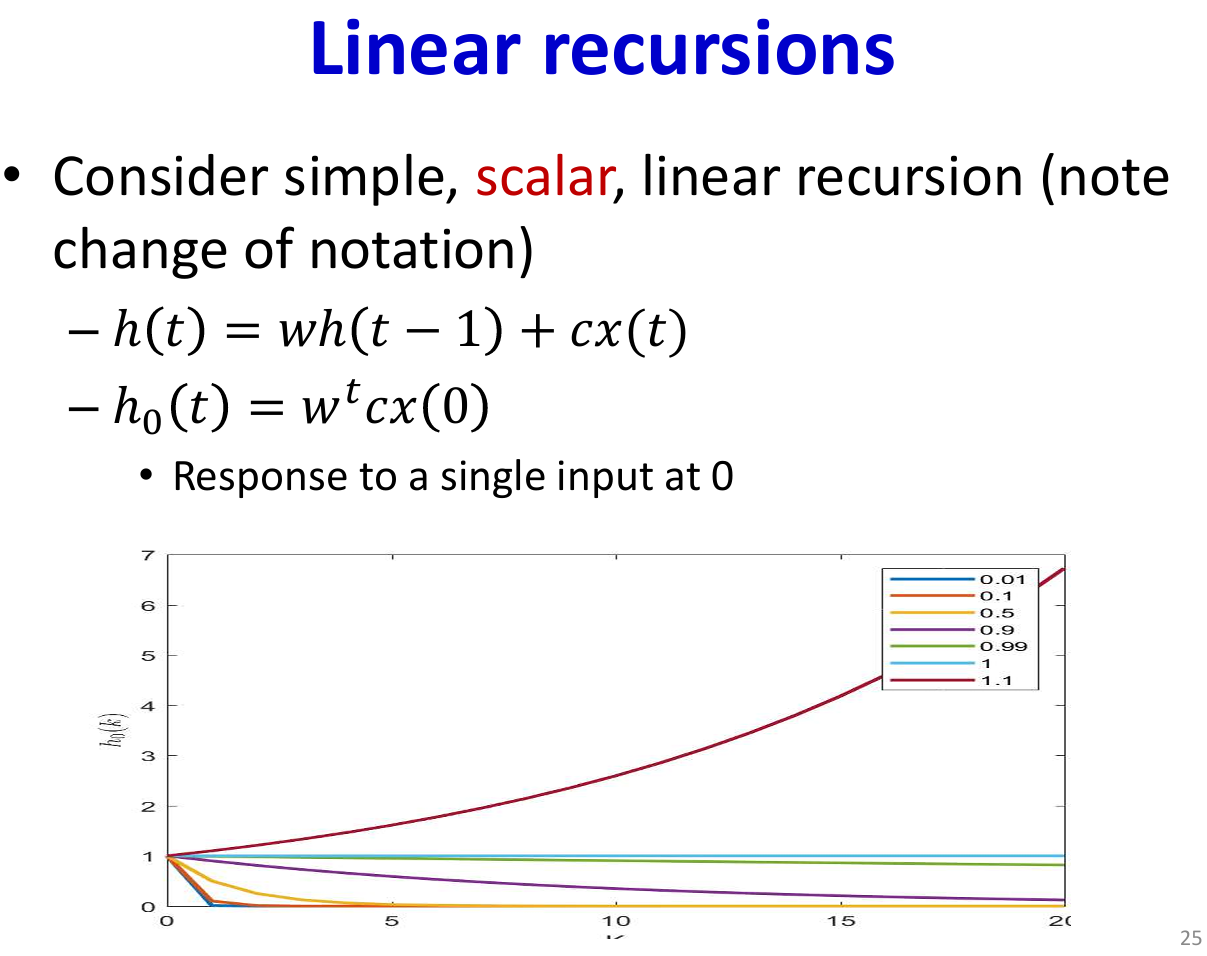

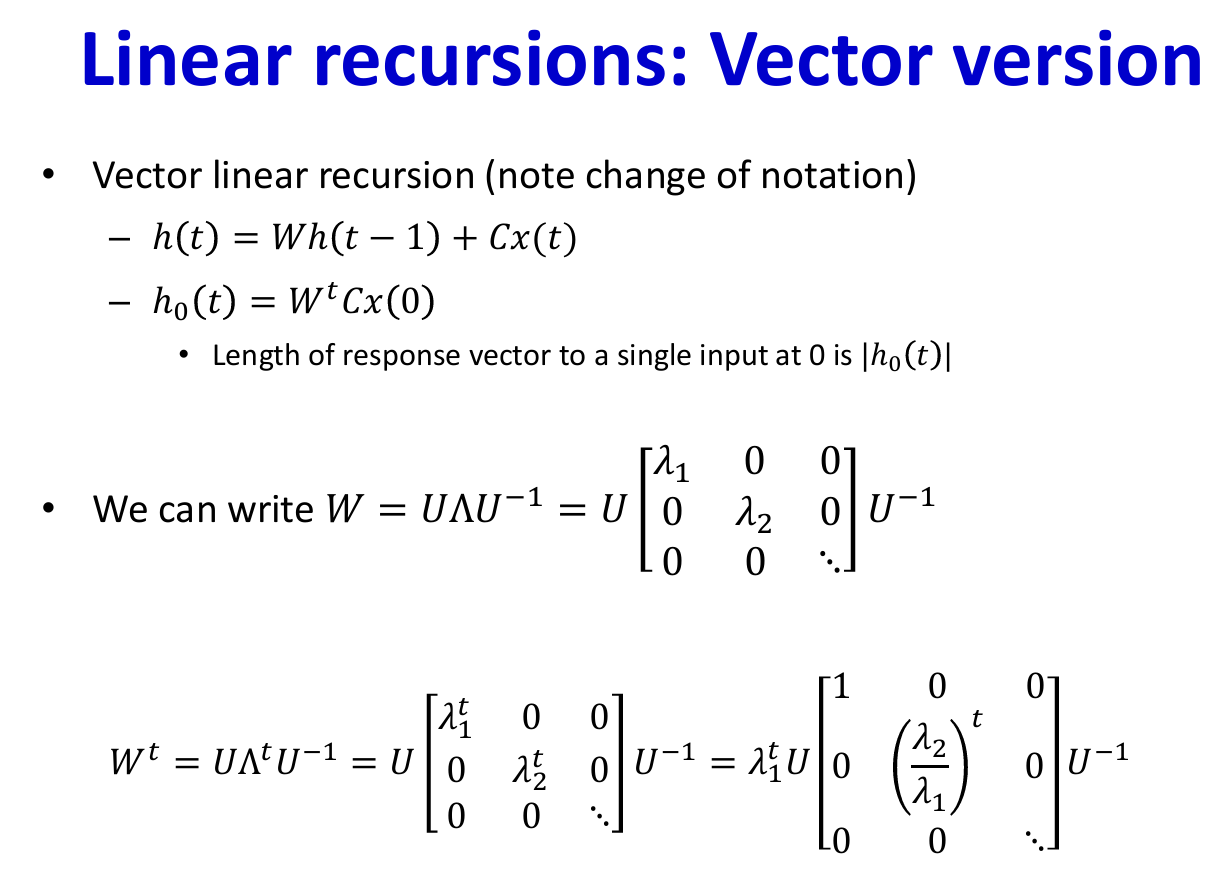

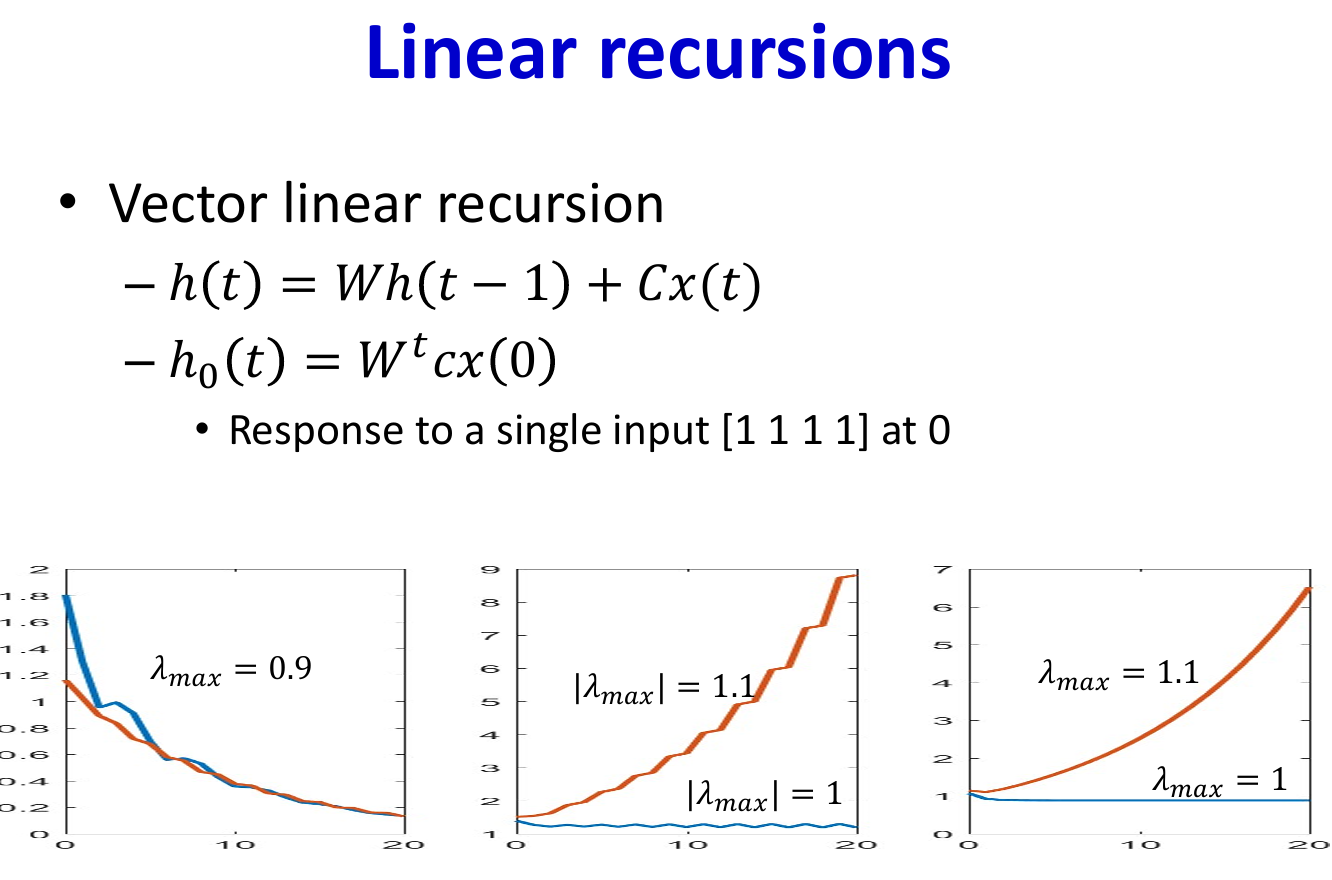

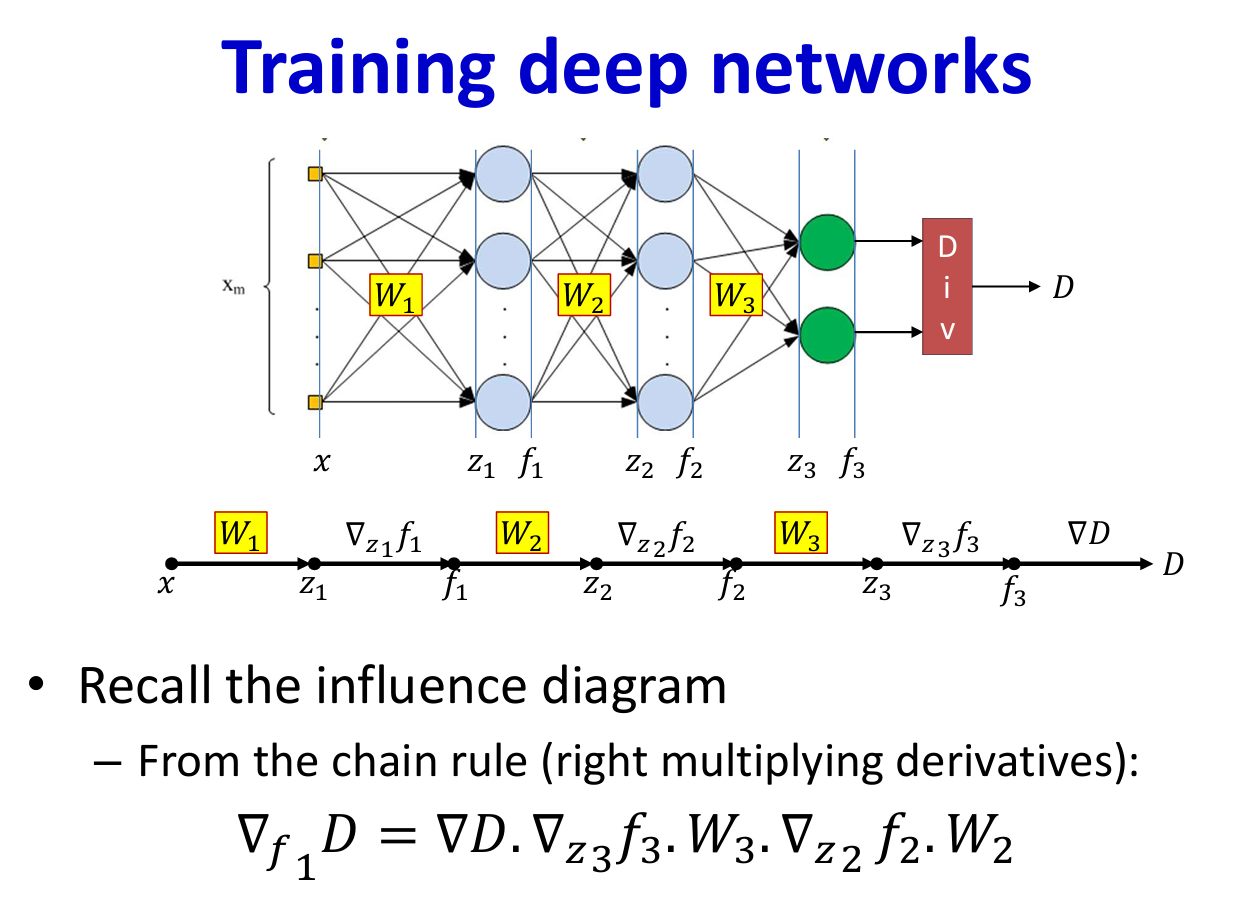

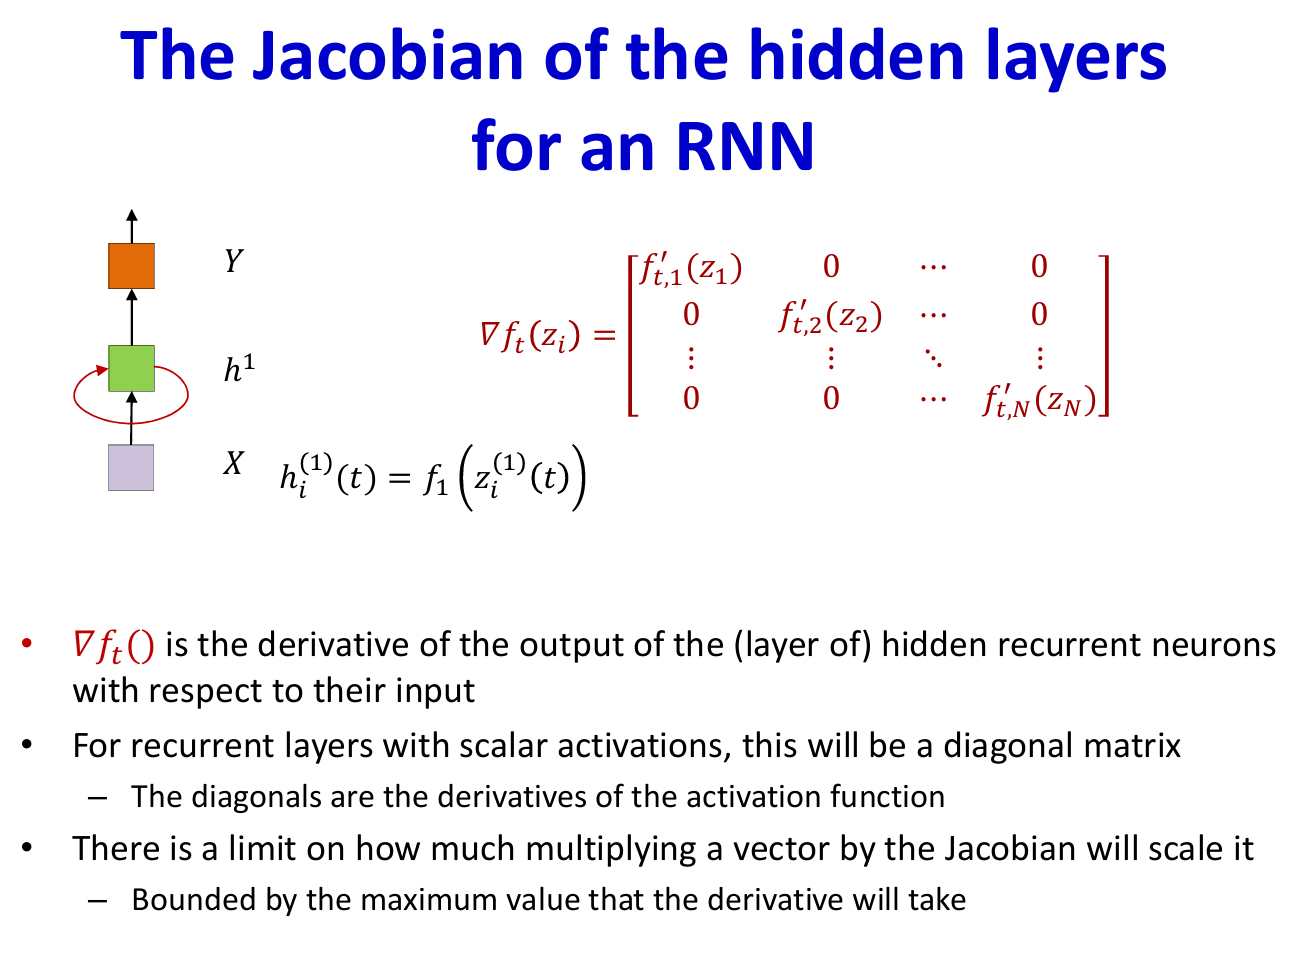

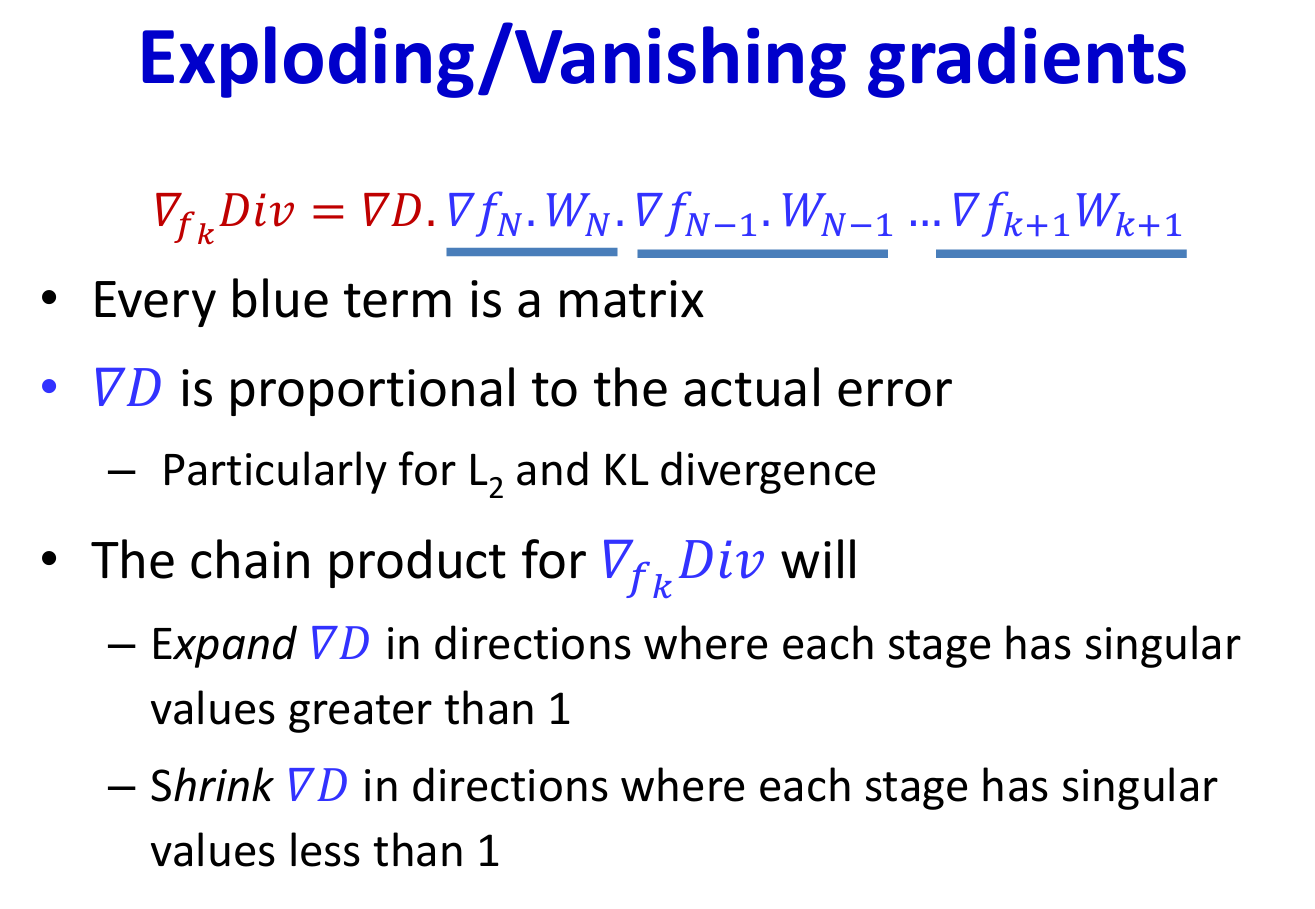

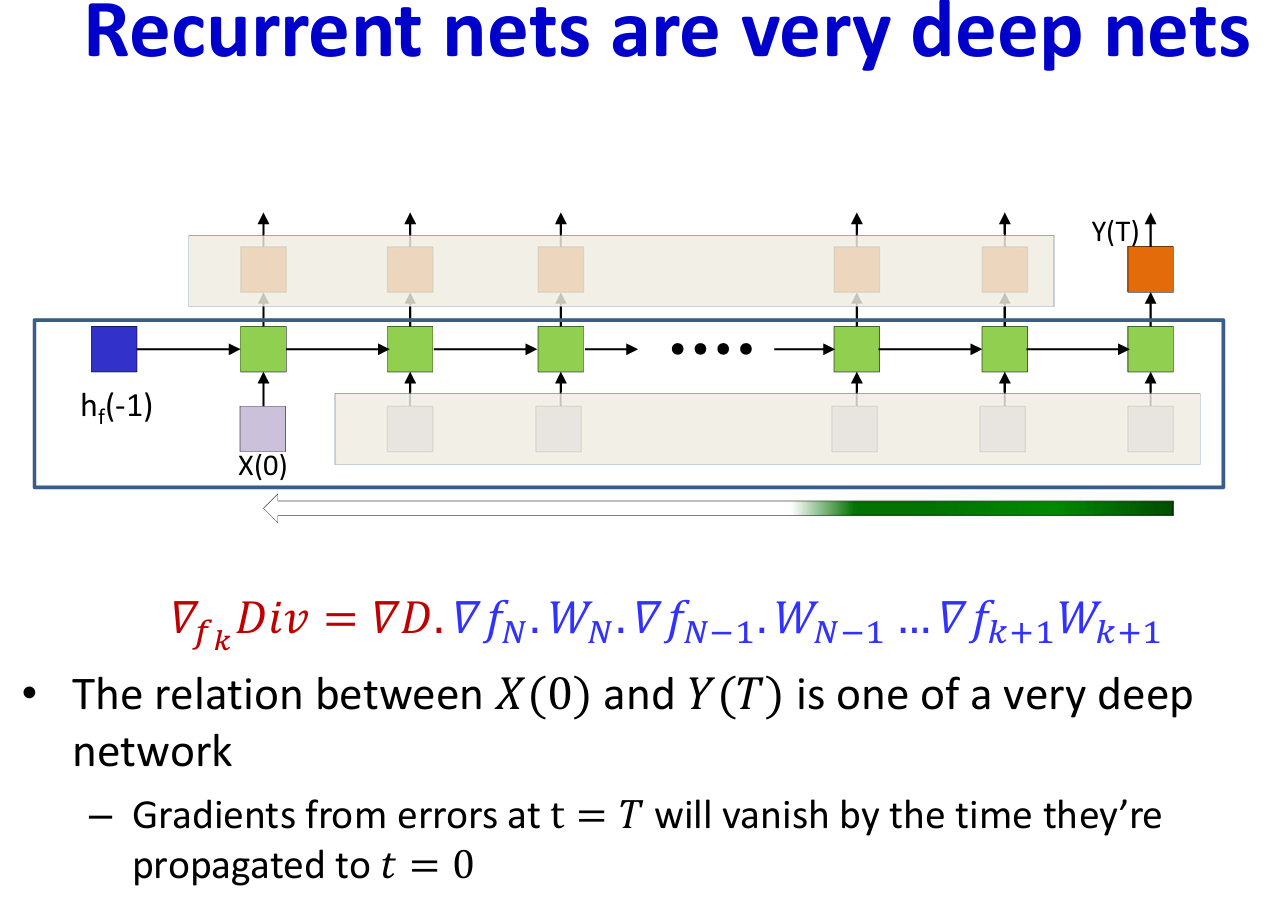

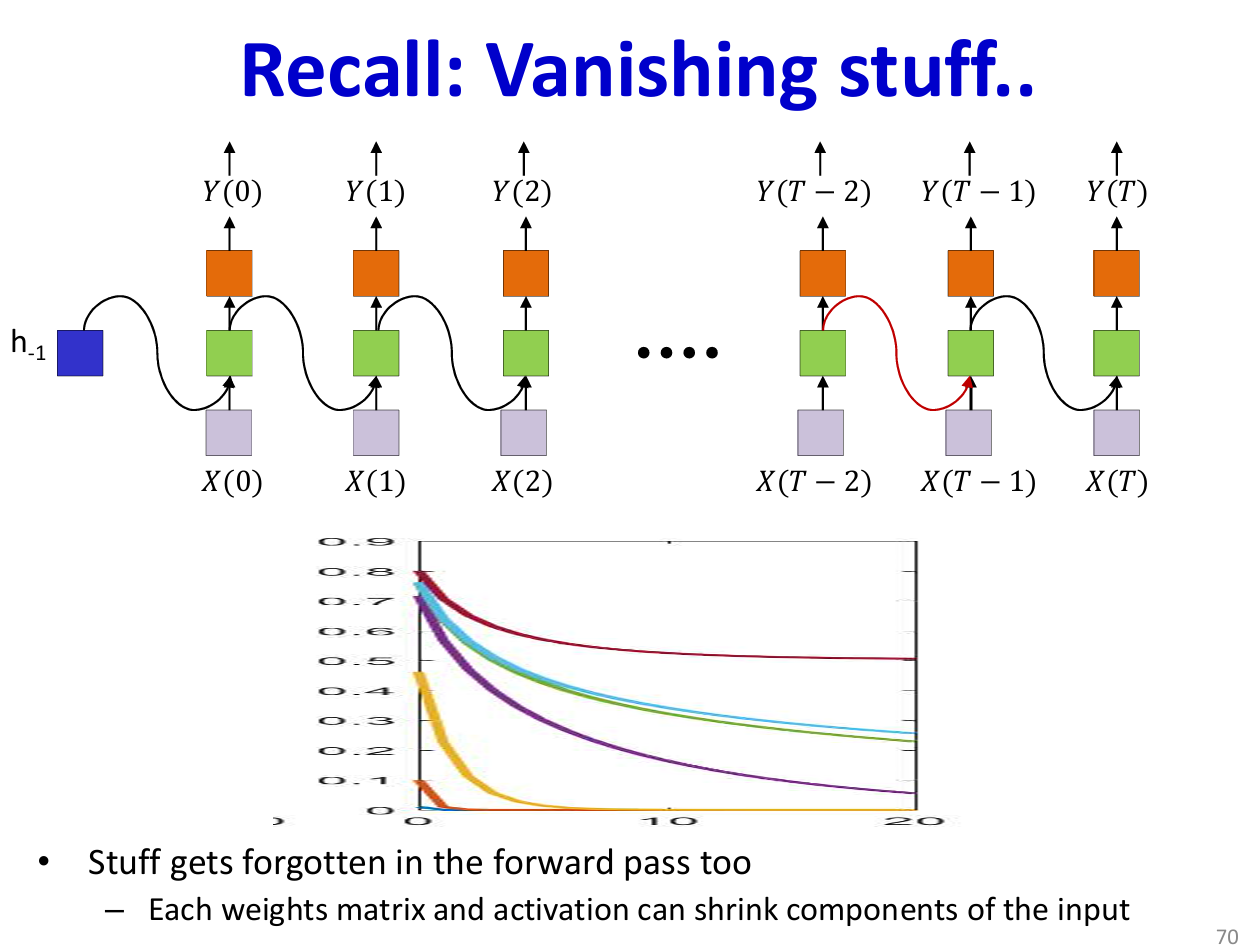


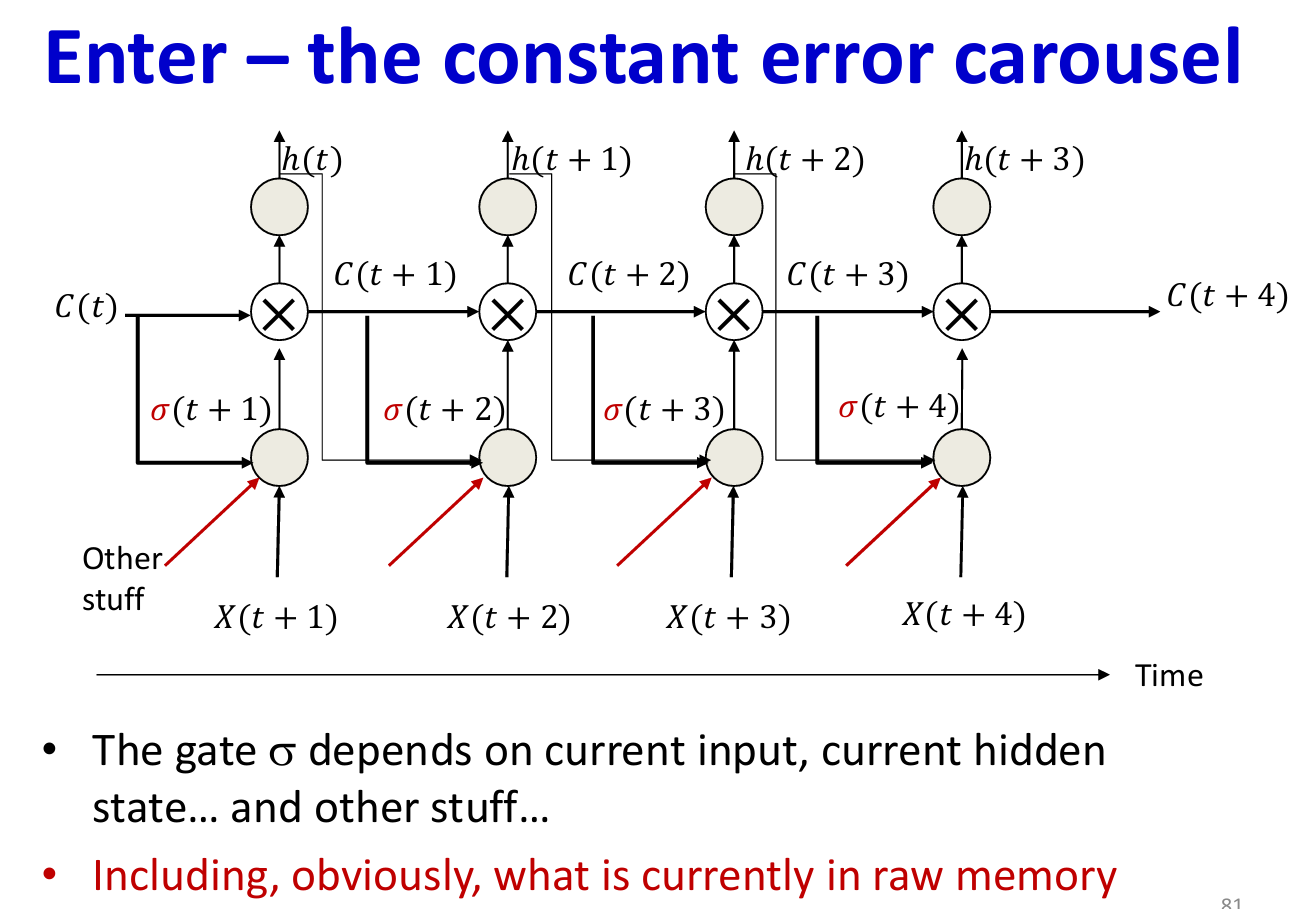

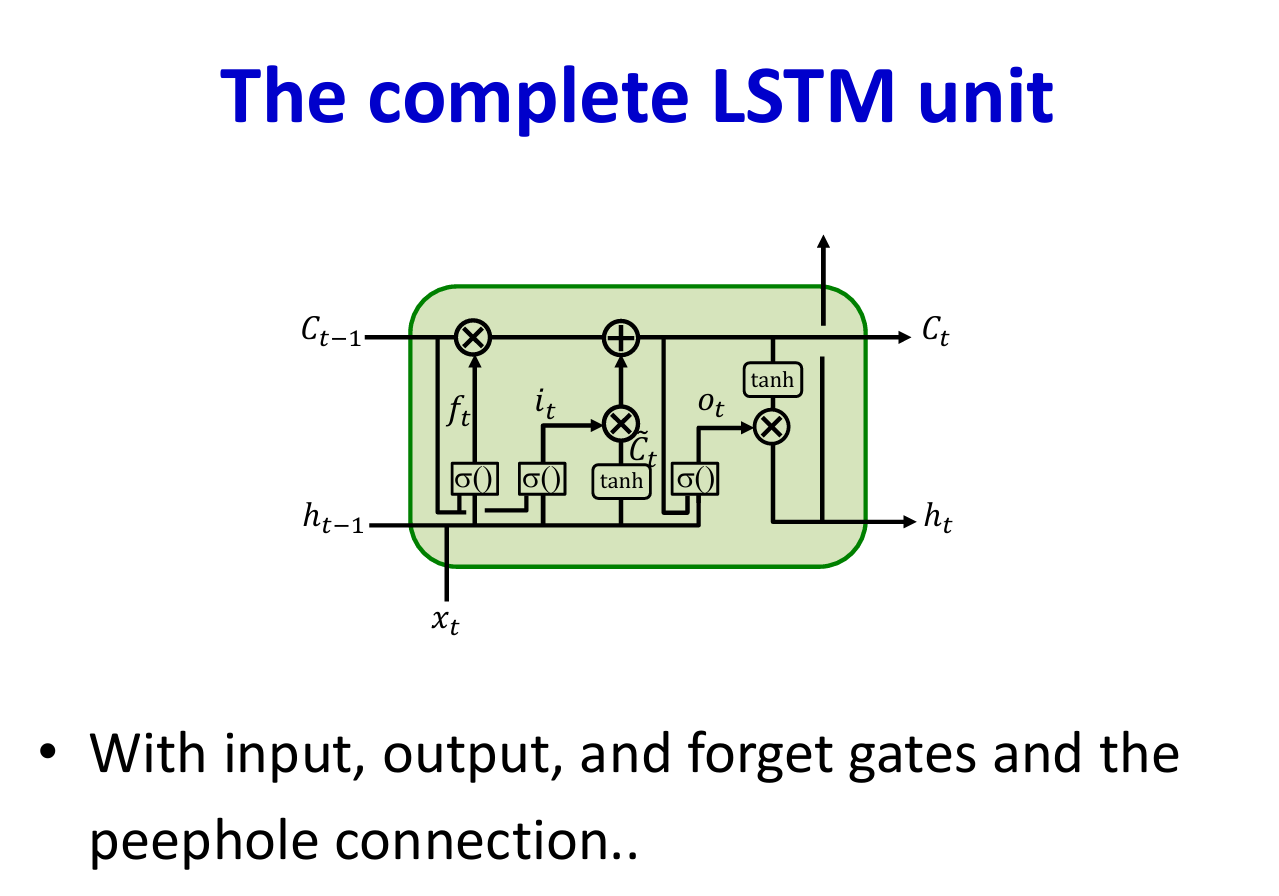

---

## Additional LSTM Reference Materials

*Supplementary slides from the instructor:*

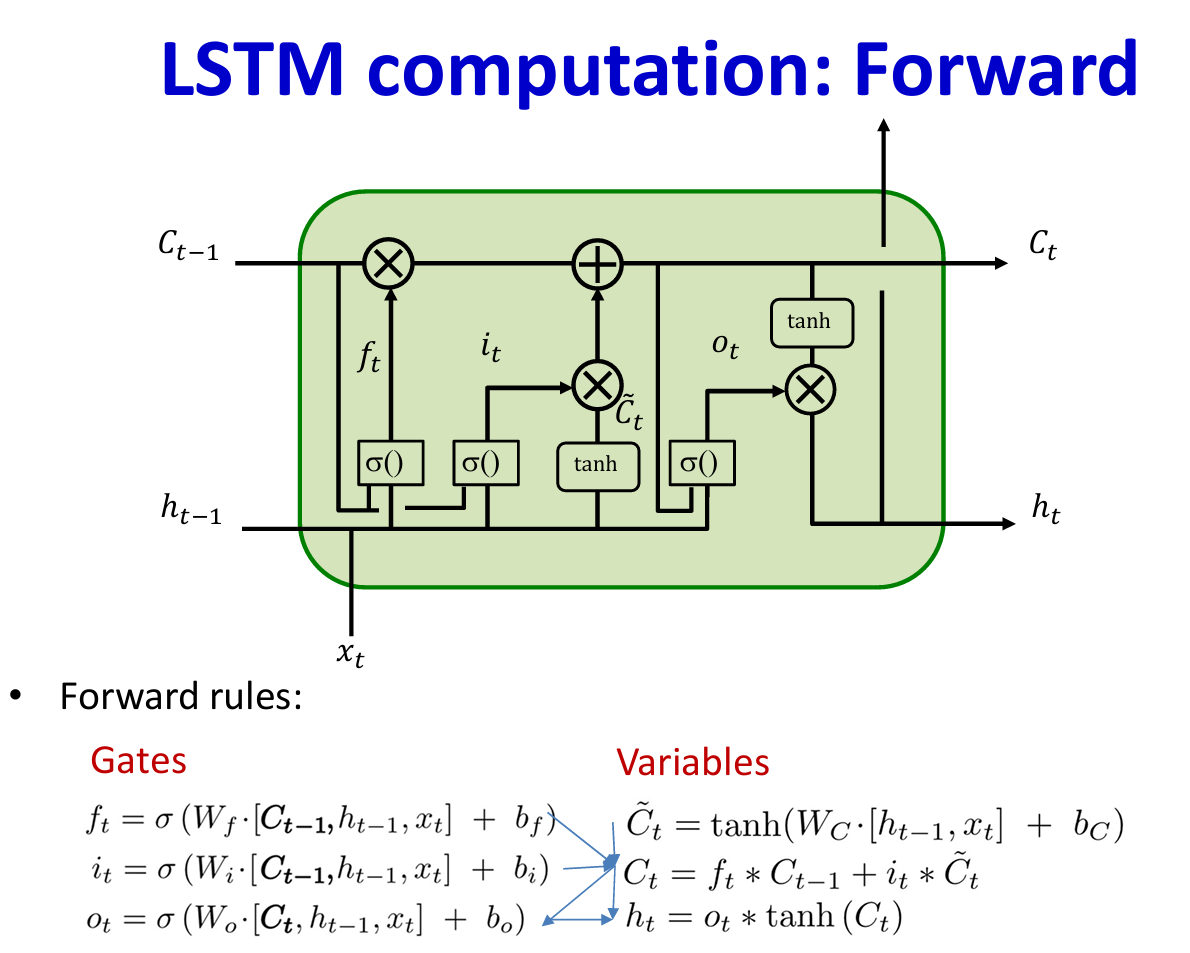

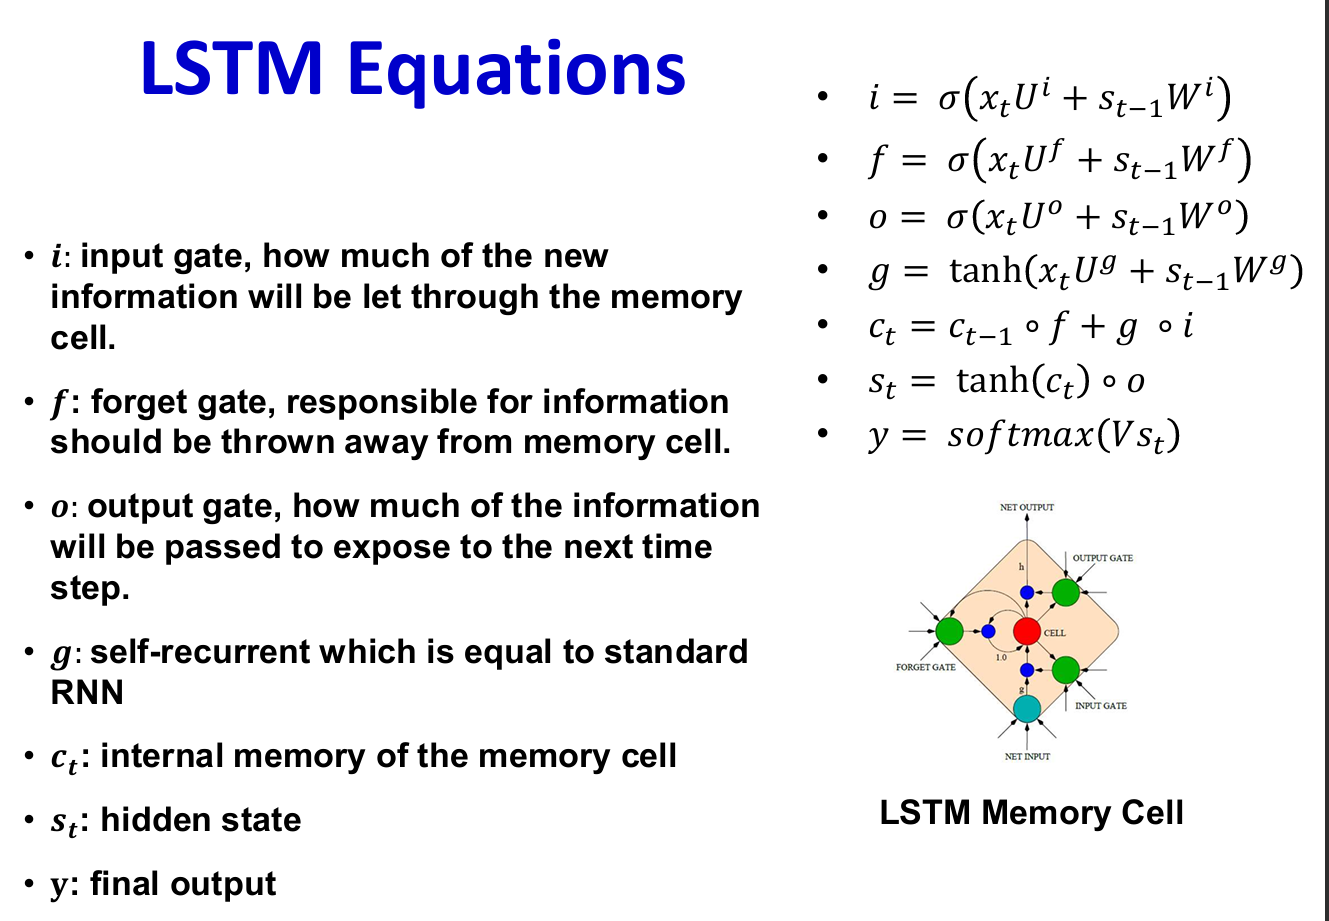

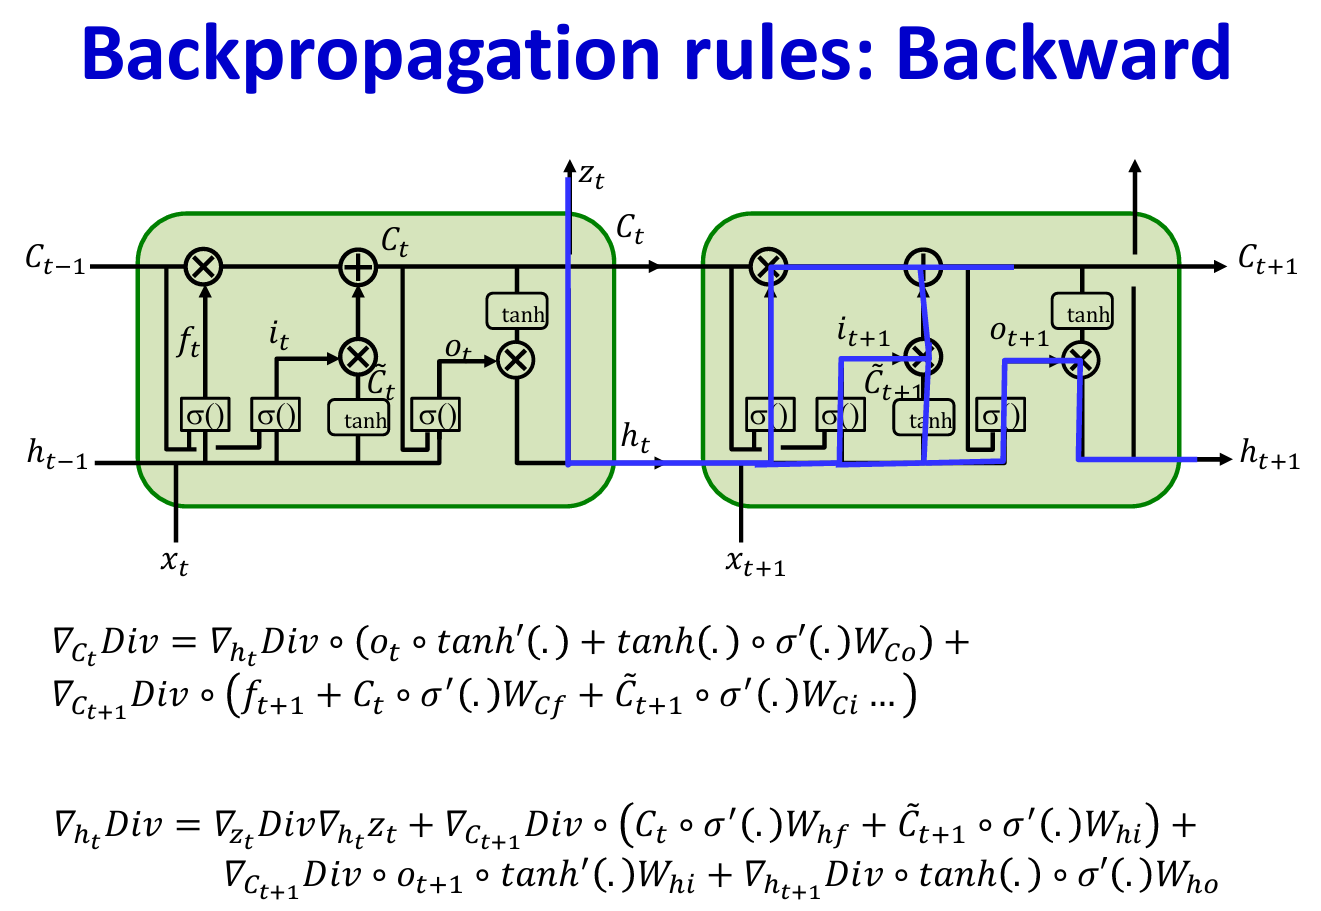

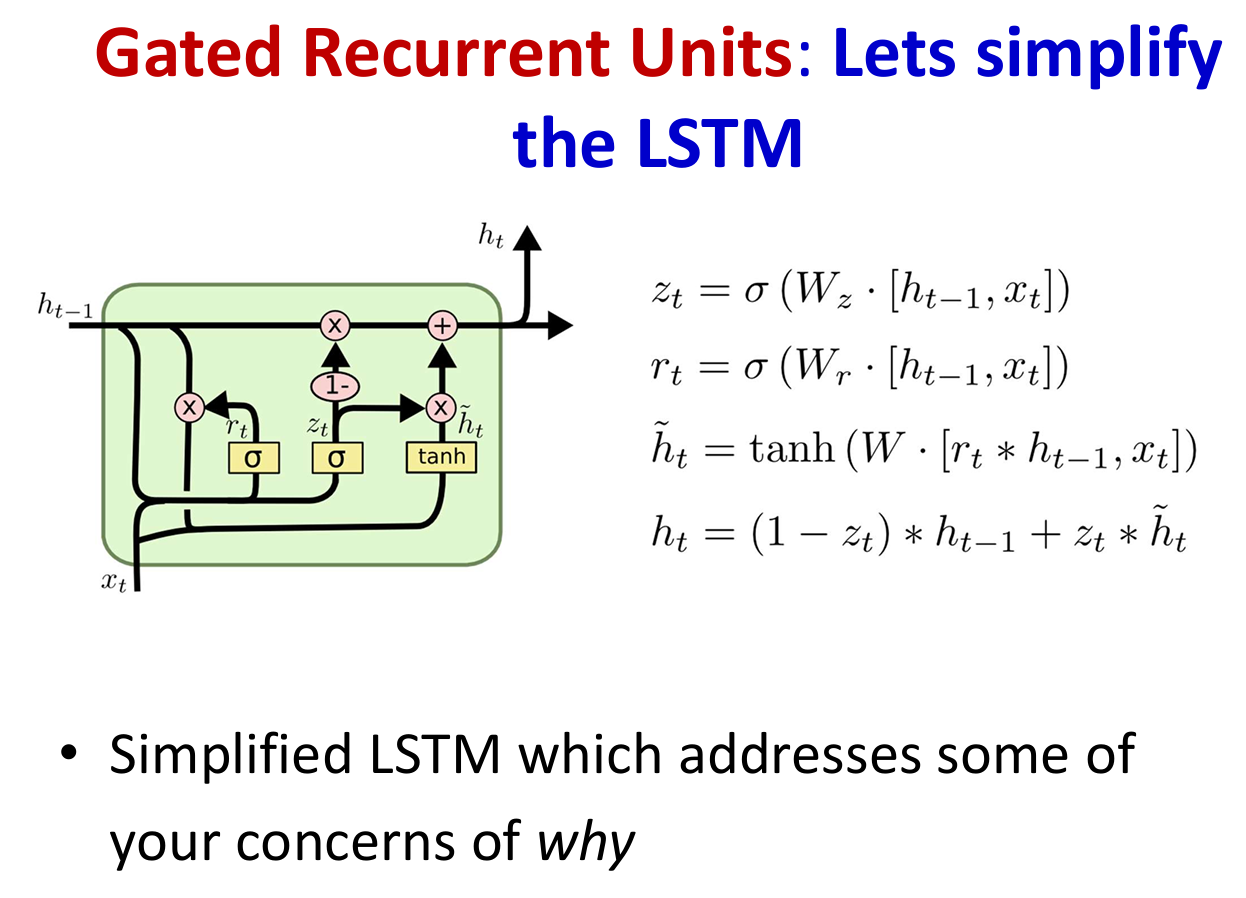

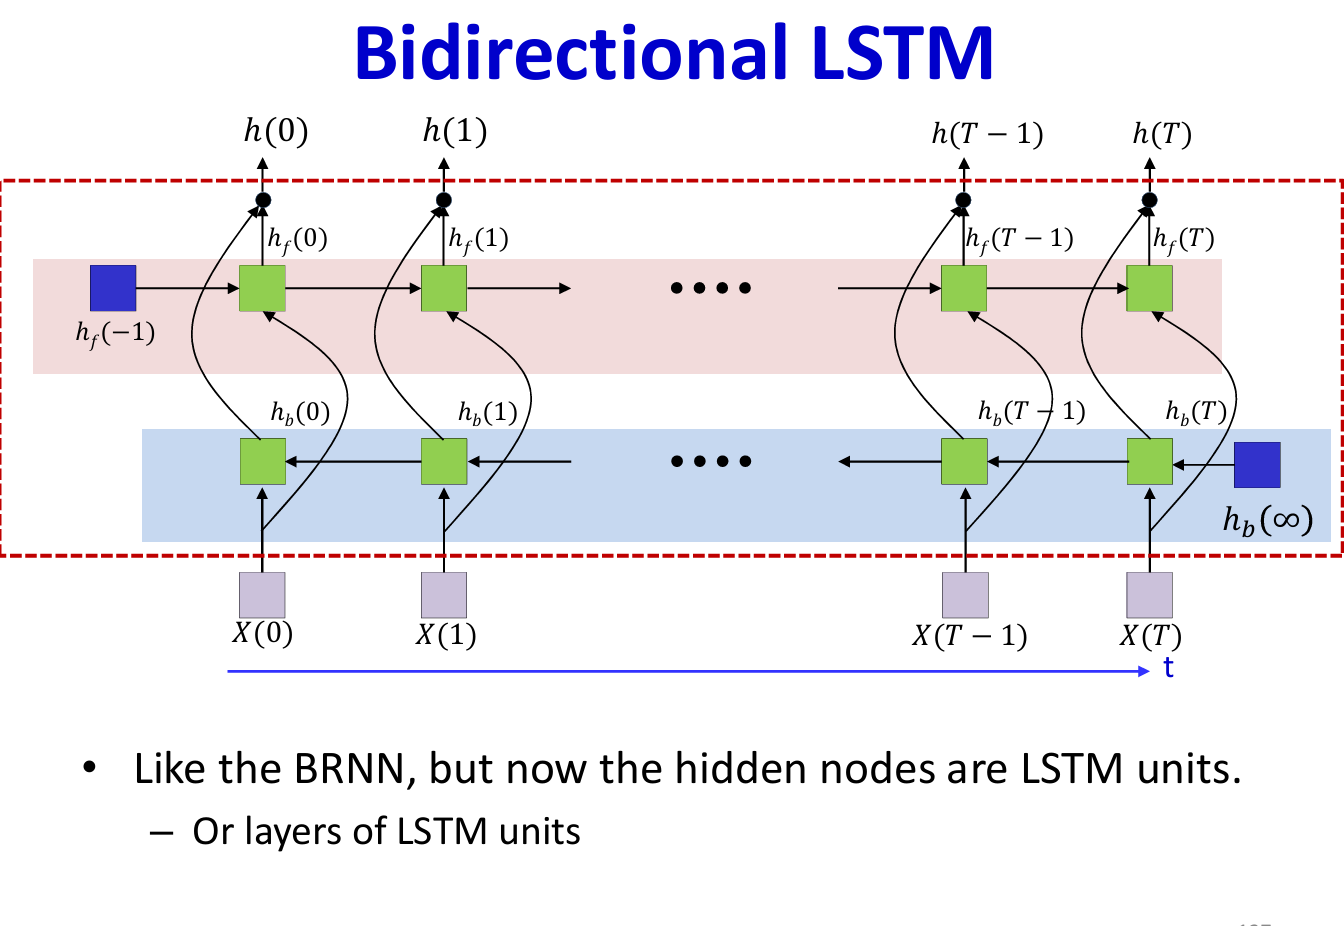

---

# Appendix: Quick Reference

## A. Notation Summary

| Symbol | Meaning |
|:-------|:--------|
| $\mathbf{h}_t$ | Hidden state at time $t$ |
| $\mathbf{x}_t$ | Input at time $t$ |
| $W$ | Recurrent weight matrix |
| $C$ | Input weight matrix |
| $\mathbf{b}$ | Bias vector |
| $\lambda_i$ | Eigenvalue of $W$ |
| $\lambda_{\max}$ | Spectral radius = $\max_i |\lambda_i|$ |
| $\sigma_{\max}(W)$ | Largest singular value of $W$ |
| $J_t$ | Jacobian of activation at time $t$ |
| $f(\cdot)$ | Activation function |

---

## B. Key Equations

**Linear RNN dynamics:**
$$\mathbf{h}_t = W^t \, \mathbf{h}_0$$

**Stability condition:**
$$|\lambda_{\max}| < 1 \implies \mathbf{h}_t \to \mathbf{0}$$

**Gradient product:**
$$\frac{\partial \mathbf{h}_T}{\partial \mathbf{h}_k} = \prod_{t=k+1}^{T} J_t \cdot W$$

**Activation derivatives:**
- Sigmoid: $\sigma'(z) = \sigma(z)(1-\sigma(z)) \leq 0.25$
- Tanh: $\tanh'(z) = 1 - \tanh^2(z) \leq 1$

---
